In [1]:
import numpy as np
import pandas as pd
import csv
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
from point_net import PointNetClassHead
from utils import normalize_point_cloud, find_surface_indices

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
import warnings
warnings.filterwarnings("ignore")

In [5]:
BATCH_SIZE = 36
NUM_CLASSES = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [6]:
point_clouds_info = pd.read_csv('point_Clouds_info.csv');
dataI = pd.read_csv('dataI_with_stage.csv') ; dataI = dataI.drop('Unnamed: 0', axis = 1)
dataP = pd.read_csv('dataP_with_stage.csv') ; dataP = dataP.drop('Unnamed: 0', axis = 1)
dataTrack = pd.read_csv('dataTrack_with_stage.csv') ; dataTrack = dataTrack.drop('Unnamed: 0', axis = 1)
dataP['subjid'] = dataP['subjid'].astype(str)  # so that we can work with sklearn group split
dataSet  = pd.concat([dataI, dataP, dataTrack])
print(dataSet.shape)
patients = dataSet.loc[dataSet['group'] != 'control']
patients.reset_index(drop=True , inplace = True)
print(patients.shape)

(4407, 308)
(2932, 308)


In [7]:
patients['Disease_Stage'] = patients['Disease_Stage'].apply(lambda x: int(x[6]) if not x.startswith('Error') else np.NaN)
# patients = patients[~np.isnan(patients['Disease_Stage'])] # Drop empty rows (where 'error' was the prefix)
print(patients.shape)
imputer = KNNImputer(n_neighbors=15, weights="uniform")
numeric_columns = patients.select_dtypes(include='number').columns
patients.loc[:,numeric_columns] = pd.DataFrame(imputer.fit_transform(patients[numeric_columns]), columns=numeric_columns)
patients.reset_index(drop=True)
print(patients.shape)
patients['Disease_Stage'] = patients['Disease_Stage'].round(0).astype(int).astype(str)

(2932, 308)
(2932, 308)


<Axes: xlabel='Left-Lateral-Ventricle', ylabel='PIN'>

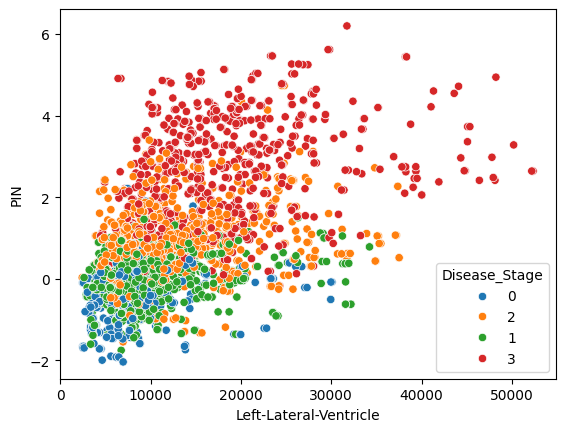

In [8]:
sns.scatterplot(x = patients['Left-Lateral-Ventricle'], y= patients['PIN'], hue = patients['Disease_Stage'])

symp-HD
torch.Size([3, 2000])


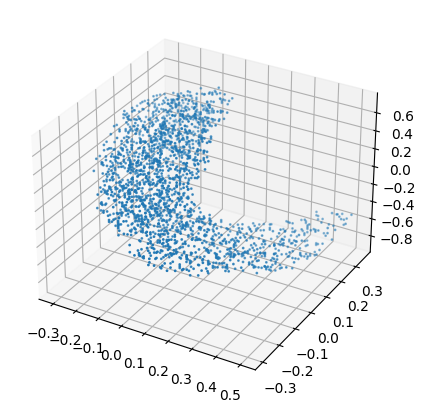

In [9]:
REGION_LABEL = 4 # Name:Left-Lateral-Ventricle
NUM_POINTS = 2000

subject_row = patients.iloc[1587]
print(subject_row['group'])
path = subject_row['identifier'] + '/mri/'
roi = nib.load(path + 'aseg.mgz')
roi_data = roi.get_fdata()
roi_data[roi_data != REGION_LABEL] = 0
P = find_surface_indices(roi_data, NUM_POINTS)
print(P.shape)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[0], P[1], P[2] , s= 1)

In [18]:
# scipy.io.savemat('point_cloud_region4.mat', {'point_cloud': P})

### Classes and Methods

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_row = self.data.iloc[idx]
        disease_stage = subject_row['Disease_Stage']
        target = subject_row['PIN']
        age = subject_row['ageAtscan']
        
        path = subject_row['identifier']

        point_clouds_row = point_clouds_info.loc[point_clouds_info['identifier'] == path]
        
        index = int(point_clouds_row['index'])
        
        n = int(point_clouds_row[f'n_{REGION_LABEL}'])
        P = pd.read_csv(f'Point_clouds/{index}/region{REGION_LABEL}.csv').to_numpy()

        if NUM_POINTS < n:
            sampled_surface_indices = np.random.choice(n, size=NUM_POINTS, replace=False)
        else:
            sampled_surface_indices = np.random.choice(n, size=NUM_POINTS, replace=True)
        P = P[:,sampled_surface_indices]
        
        return torch.Tensor(P), torch.tensor(target, dtype = torch.float), disease_stage , age

In [23]:
skf_gen = StratifiedGroupKFold(n_splits=6, shuffle=False).split(patients, y=patients['Disease_Stage'] , groups= patients['subjid'])
train_ind , not_train_ind = next(iter(skf_gen))
X_train = patients.iloc[train_ind] 
X_not_train = patients.iloc[not_train_ind]

skf_gen = StratifiedGroupKFold(n_splits=2, shuffle=False).split(X_not_train, y=X_not_train['Disease_Stage'] , groups= X_not_train['subjid'])
test_ind , valid_ind = next(iter(skf_gen))
X_test = X_not_train.iloc[test_ind] 
X_valid = X_not_train.iloc[valid_ind]

print(patients.shape)
print(X_train.shape , X_not_train.shape , X_test.shape , X_valid.shape)

whole_dataset = CustomDataset(patients)
train_dataset = CustomDataset(X_train)
valid_dataset = CustomDataset(X_valid)
test_dataset = CustomDataset(X_test)
not_train_dataset = CustomDataset(X_not_train)

whole_loader = DataLoader(whole_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
not_train_loader = DataLoader(not_train_dataset, batch_size=BATCH_SIZE, shuffle=False)

(2932, 308)
(2443, 308) (489, 308) (244, 308) (245, 308)


In [24]:
X_test.to_csv('X_test.csv')

## Region 4

In [54]:
REGION_LABEL = 4 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 3000
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_40_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)

# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)


np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array, age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:57<00:00,  8.20s/it]


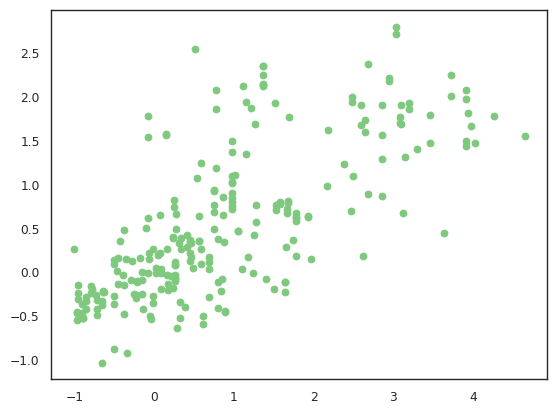

In [55]:
plt.scatter(x=targets_array, y=preds_array)

## Region 26

In [56]:
REGION_LABEL = 26 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 400
GLOBAL_FEATS = 64

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_30_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)

# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)


np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array, age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


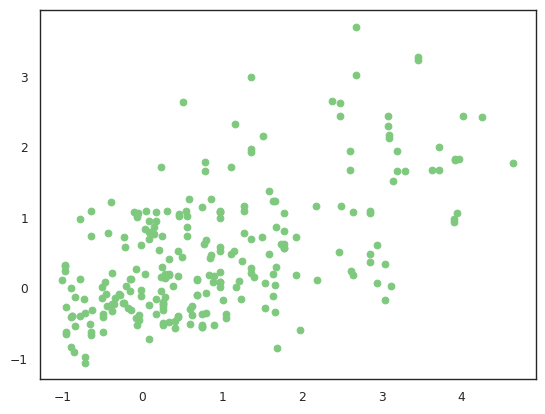

In [57]:
plt.scatter(x=targets_array, y=preds_array)

## Region 18

In [58]:
REGION_LABEL = 18 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 1500
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_32_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)


# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)



np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array ,
         disease_stage_array=disease_stage_array, age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]


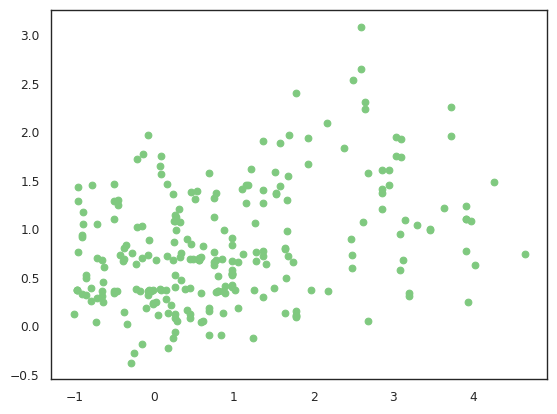

In [59]:
plt.scatter(x=targets_array, y=preds_array)

## Region 17

In [60]:
REGION_LABEL = 17 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 3500
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_46_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)


# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)

np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array, age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


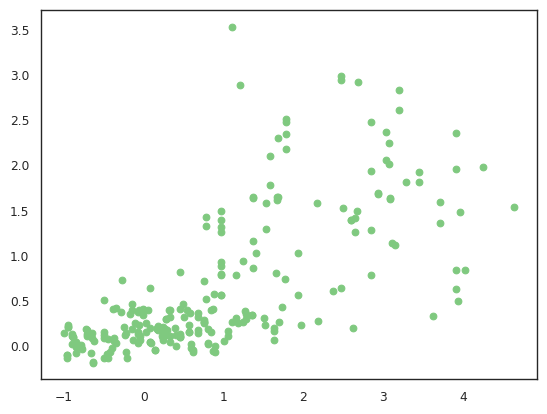

In [61]:
plt.scatter(x=targets_array, y=preds_array)

## Region 13

In [62]:
REGION_LABEL = 13 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 1500
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_33_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)

# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)


np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array, age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


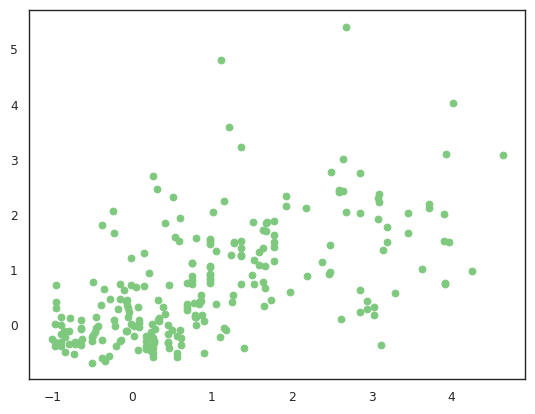

In [63]:
plt.scatter(x=targets_array, y=preds_array)

## Region 10

In [64]:
REGION_LABEL = 10 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 2500
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_81_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)

# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)


np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array , age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:38<00:00,  5.45s/it]


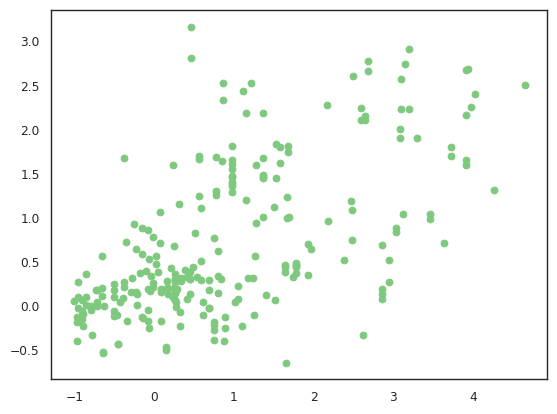

In [65]:
plt.scatter(x=targets_array, y=preds_array)

## Region 11

In [66]:
REGION_LABEL = 11 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 2400
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_50_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)

# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)

np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array, age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


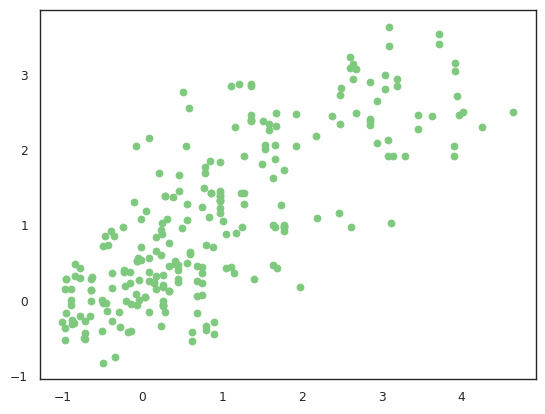

In [67]:
plt.scatter(x=targets_array, y=preds_array)

## Region 12

In [68]:
REGION_LABEL = 12 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 3000
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_48_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []
age_array = []

for i, (points, targets, stage, age) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    age_array.append(age)

# Convert the list of arrays to a single numpy array
preds_array = np.concatenate(preds_array, axis=0)
targets_array = np.concatenate(targets_array, axis=0)
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)
age_array = np.concatenate(age_array, axis=0)

np.savez('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz', preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array, age_array = age_array)

Processing test data: 100%|██████████| 7/7 [00:22<00:00,  3.17s/it]


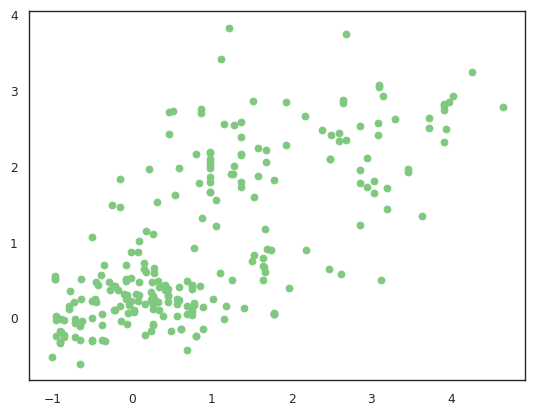

In [69]:
plt.scatter(x=targets_array, y=preds_array)

### t-SNE plot for Shape Descriptors

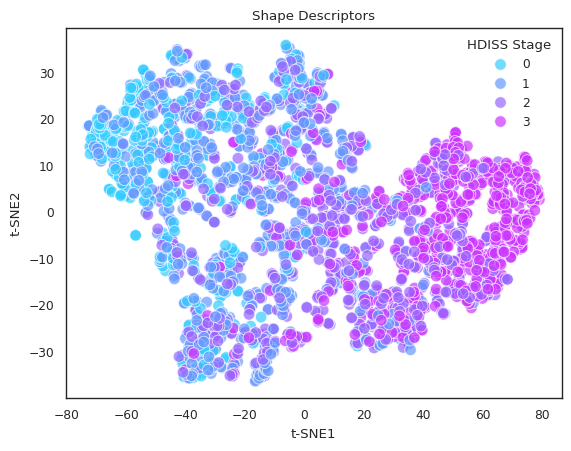

In [97]:
sns.set_theme(style="white", palette="Accent")
sns.set_context("paper")

global_features_array_train = []
disease_stage_array_train = []

for i, REGION_LABEL in enumerate([4, 11, 12, 13]): # , 10 , 26
    data = np.load('visualization_arrays_train/' +'region' + str(REGION_LABEL) +'.npz')
    global_features_array_train.append(np.array(data ['global_features_array']))
    disease_stage_array_train = data ['disease_stage_array']
    
global_features_array_train = np.concatenate(global_features_array_train, axis=1)

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the global features
tsne_result = tsne.fit_transform(global_features_array_train)
# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

# Concatenate the t-SNE results with the disease stage column
tsne_df['Disease_Stage'] = disease_stage_array_train

# Plot t-SNE results with seaborn
sns.scatterplot(data=tsne_df  , x='t-SNE1', y='t-SNE2', hue = 'Disease_Stage', alpha = 0.7, s= 70,
                palette = 'cool', hue_order = ['0','1','2','3'])

plt.legend(title='HDISS Stage', frameon = False)

plt.title('Shape Descriptors')
plt.savefig('tSNE_PointNet_train.svg', bbox_inches='tight')
plt.show()

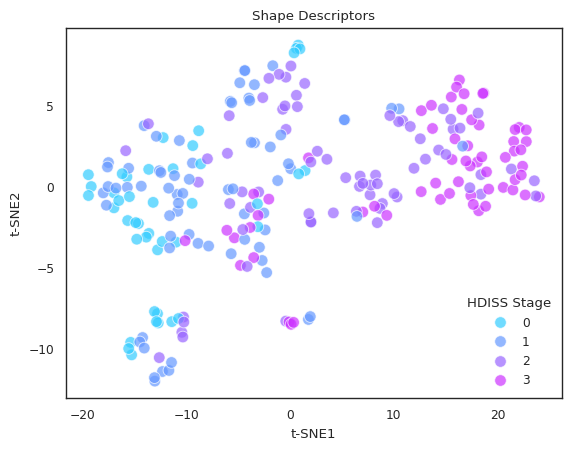

In [98]:
sns.set_theme(style="white", palette="Accent")
sns.set_context("paper")

global_features_array_test = []
disease_stage_array_test = []

for i, REGION_LABEL in enumerate([4, 11, 12, 13]): # , 10 , 26
    data = np.load('visualization_arrays_test/' +'region' + str(REGION_LABEL) +'.npz')
    global_features_array_test.append(np.array(data ['global_features_array']))
    disease_stage_array_test = data ['disease_stage_array']
    
global_features_array_test = np.concatenate(global_features_array_test, axis=1)

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the global features
tsne_result = tsne.fit_transform(global_features_array_test)
# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

# Concatenate the t-SNE results with the disease stage column
tsne_df['Disease_Stage'] = disease_stage_array_test

# Plot t-SNE results with seaborn
sns.scatterplot(data=tsne_df  , x='t-SNE1', y='t-SNE2', hue = 'Disease_Stage', alpha = 0.7, s= 70,
                palette = 'cool', hue_order = ['0','1','2','3'])

plt.legend(title='HDISS Stage', frameon = False)

plt.title('Shape Descriptors')
plt.savefig('tSNE_PointNet_test.svg', bbox_inches='tight')
plt.show()

In [ ]:
sns.set_theme(style="white", palette="Accent")
sns.set_context("paper")

global_features_array = []
disease_stage_array = []

for i, REGION_LABEL in enumerate([ 4 , 11 , 12 , 13, 26]):
    data = np.load('visualization_arrays/' +'region' + str(REGION_LABEL) +'.npz')
    global_features_array.append(np.array(data ['global_features_array']))
    disease_stage_array = data ['disease_stage_array']
    
global_features_array = np.concatenate(global_features_array, axis=1)

# Initialize t-SNE
tsne = TSNE(n_components=1, random_state=42)

# Fit and transform the global features
tsne_result = tsne.fit_transform(global_features_array)
# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1'])

# Concatenate the t-SNE results with the disease stage column
tsne_df['Disease_Stage'] = disease_stage_array

# Plot t-SNE results with seaborn
sns.scatterplot(data=tsne_df  , x='t-SNE1', y=0, hue = 'Disease_Stage', alpha = 0.7, s= 50,
                palette = 'cool', hue_order = ['0','1','2','3'])

plt.legend(title='HDISS Stage', frameon = False)

plt.ylim([-0.002, 0.002])
plt.title('Shape Descriptors')
plt.savefig('tSNE_PointNet.svg', bbox_inches='tight')
plt.show()

### t-SNE plot for volumes

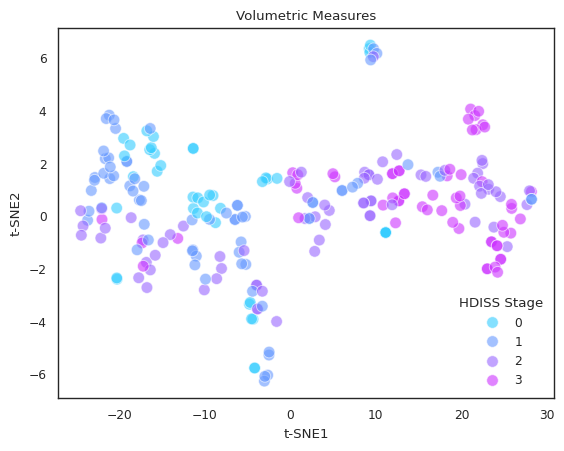

In [95]:
sns.set_theme(style="white", palette="Accent")
sns.set_context("paper")

X_test = X_test.reset_index(drop=True)
subcortical_regions = X_test[['PIN','Left-Lateral-Ventricle','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Accumbens-area', 'Left-Thalamus']]

# Extract disease stage for hue
disease_stage = X_test['Disease_Stage']
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the global features
tsne_result = tsne.fit_transform(subcortical_regions)
# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

# Concatenate the t-SNE results with the disease stage column
tsne_df['Disease_Stage'] = disease_stage

# Plot t-SNE results with seaborn
sns.scatterplot(data=tsne_df  , x='t-SNE1', y='t-SNE2', hue = 'Disease_Stage', alpha = 0.6, s= 70,
                palette = 'cool', hue_order = ['0','1','2','3'])

plt.legend(title='HDISS Stage', frameon = False , loc='lower right')

plt.title('Volumetric Measures')
plt.savefig('tSNE_Volumetric.svg', bbox_inches='tight')
plt.show()

In [16]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    x_limits = ax.get_xlim()
    x_vals = np.array(x_limits)
    y_vals = x_vals  * slope + intercept
    ax.set_ylim(x_limits)
    ax.plot(x_vals, y_vals, '--', color='green', alpha=0.8)

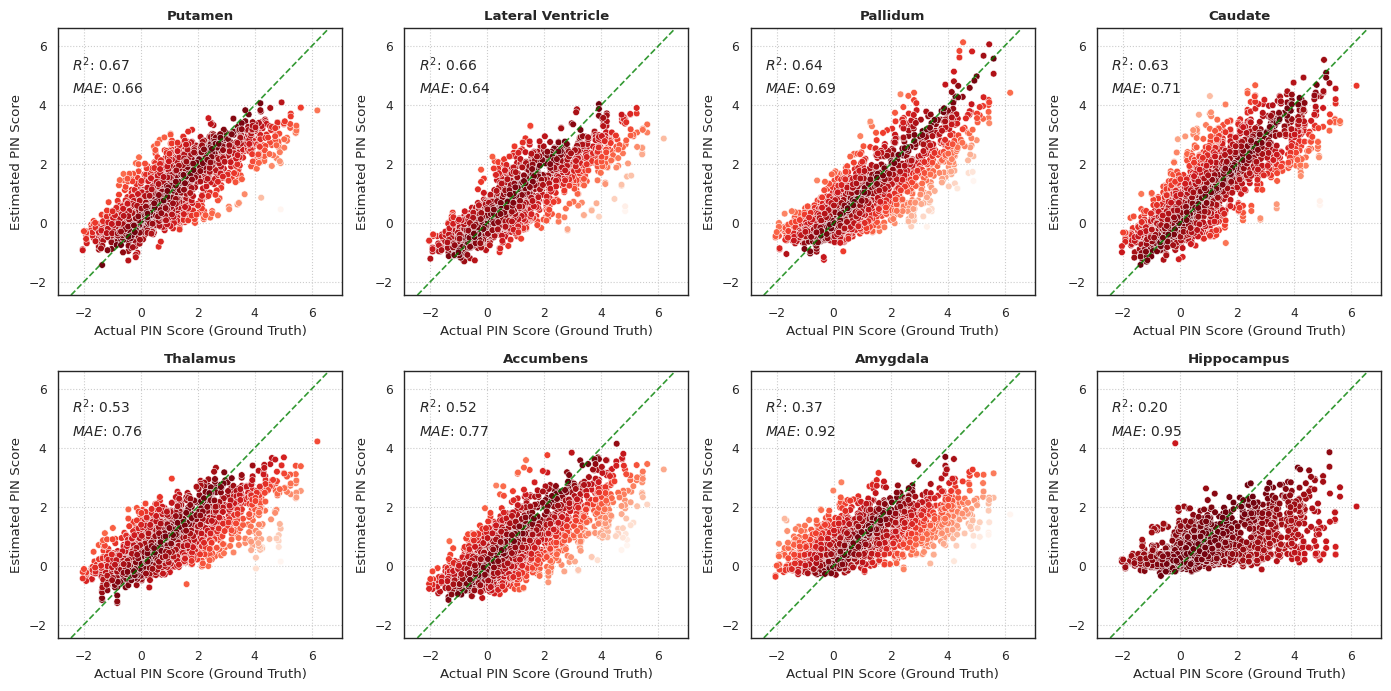

In [76]:
# Define titles and subplot dimensions
# sns.set_context(context=None, font_scale=1)
# sns.set_style("darkgrid")
titles = ['Putamen', 'Lateral Ventricle' , 'Pallidum', 'Caudate', 'Thalamus', 'Accumbens', 'Amygdala', 'Hippocampus']

rows, cols = 2, 4

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(14, 7))
axs = axs.flatten()

for i, REGION_LABEL in enumerate([12, 4, 13, 11, 10, 26, 18, 17]):
    data = np.load('visualization_arrays_train/' + 'region' + str(REGION_LABEL) + '.npz')
    preds_array = data['preds_array'].squeeze()
    targets_array = data['targets_array']
    
    # Create a scatter plot
    sns.scatterplot(x=targets_array, y=preds_array, hue=np.abs(targets_array - preds_array), palette='Reds_r', ax=axs[i])
    axs[i].legend('' , frameon = False)
    axs[i].set_title(titles[i],fontweight="bold")
    axs[i].grid(linestyle=':')
    axs[i].set_xlabel('Actual PIN Score (Ground Truth)')
    axs[i].set_ylabel('Estimated PIN Score')
    
    # Add abline
    abline(slope=1, intercept=0, ax=axs[i])
    
    # Add legend as text
    mae = mean_absolute_error(targets_array, preds_array)
    r2 = r2_score(targets_array, preds_array)
    # r = scipy.stats.pearsonr(targets_array, preds_array)
    # _, _, r_value, _, _ = scipy.stats.linregress(preds_array, targets_array)
    # r2 = r_value**2
    
    axs[i].text(0.05, 0.9, f'$R^2$: {r2:.2f}', transform=axs[i].transAxes, fontsize=10, verticalalignment='top')
    axs[i].text(0.05, 0.8, f'$MAE$: {mae:.2f}', transform=axs[i].transAxes, fontsize=10, verticalalignment='top')

    plt.tight_layout()

plt.savefig('Pin_Prediction.svg', bbox_inches='tight')
plt.savefig('Pin_Prediction.pdf', bbox_inches='tight')
plt.show()

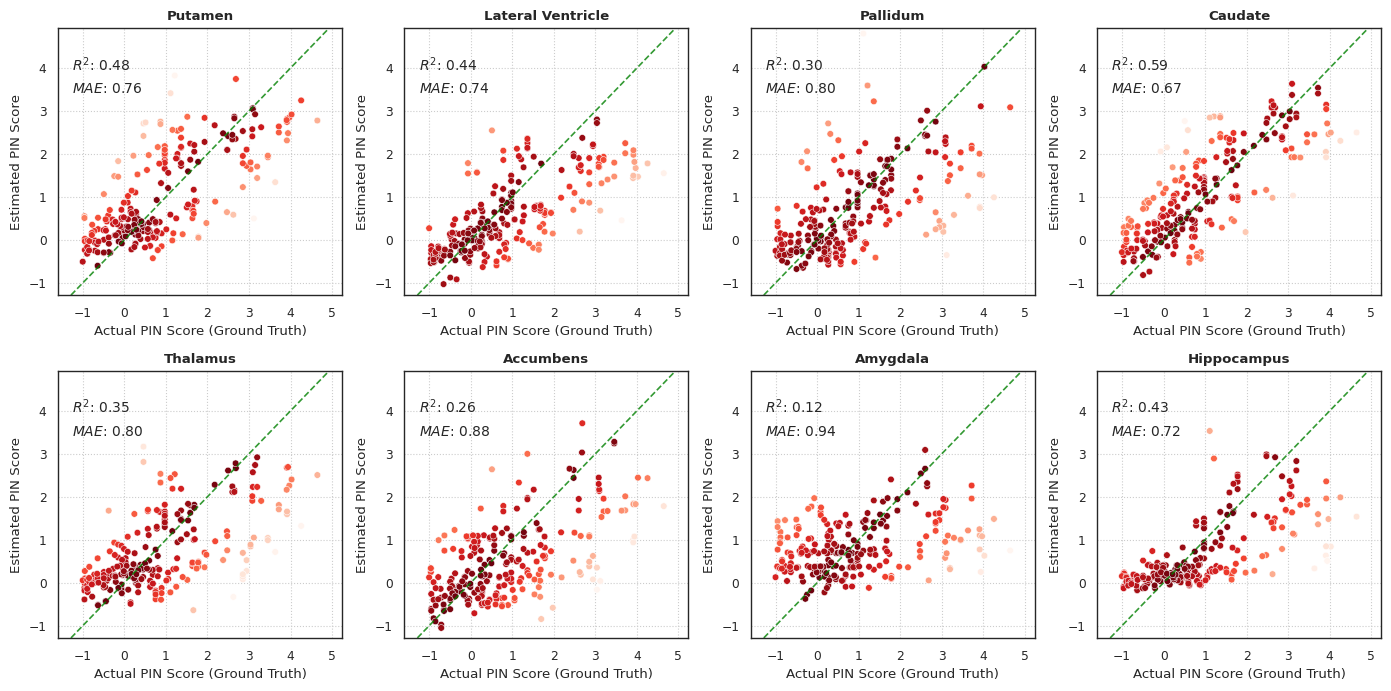

In [86]:
# Define titles and subplot dimensions
# sns.set_context(context=None, font_scale=1)
# sns.set_style("darkgrid")
titles = ['Putamen', 'Lateral Ventricle' , 'Pallidum', 'Caudate', 'Thalamus', 'Accumbens', 'Amygdala', 'Hippocampus']

rows, cols = 2, 4

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(14, 7))
axs = axs.flatten()

for i, REGION_LABEL in enumerate([12, 4, 13, 11, 10, 26, 18, 17]):
    data = np.load('visualization_arrays_test/' + 'region' + str(REGION_LABEL) + '.npz')
    preds_array = data['preds_array'].squeeze()
    targets_array = data['targets_array']
    
    # Create a scatter plot
    sns.scatterplot(x=targets_array, y=preds_array, hue=np.abs(targets_array - preds_array), palette='Reds_r', ax=axs[i])
    axs[i].legend('' , frameon = False)
    axs[i].set_title(titles[i],fontweight="bold")
    axs[i].grid(linestyle=':')
    axs[i].set_xlabel('Actual PIN Score (Ground Truth)')
    axs[i].set_ylabel('Estimated PIN Score')
    
    # Add abline
    abline(slope=1, intercept=0, ax=axs[i])
    
    # Add legend as text
    mae = mean_absolute_error(targets_array, preds_array)
    r2 = r2_score(targets_array, preds_array)
    # r = scipy.stats.pearsonr(targets_array, preds_array)
    # _, _, r_value, _, _ = scipy.stats.linregress(preds_array, targets_array)
    # r2 = r_value**2
    
    axs[i].text(0.05, 0.9, f'$R^2$: {r2:.2f}', transform=axs[i].transAxes, fontsize=10, verticalalignment='top')
    axs[i].text(0.05, 0.8, f'$MAE$: {mae:.2f}', transform=axs[i].transAxes, fontsize=10, verticalalignment='top')

    plt.tight_layout()

plt.savefig('Pin_Prediction.svg', bbox_inches='tight')
plt.savefig('Pin_Prediction.pdf', bbox_inches='tight')
plt.show()


--- Volumetric Features ---
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.42      0.49        43
           1       0.53      0.66      0.59        70
           2       0.46      0.34      0.39        70
           3       0.55      0.67      0.61        61

    accuracy                           0.53       244
   macro avg       0.53      0.52      0.52       244
weighted avg       0.52      0.53      0.52       244



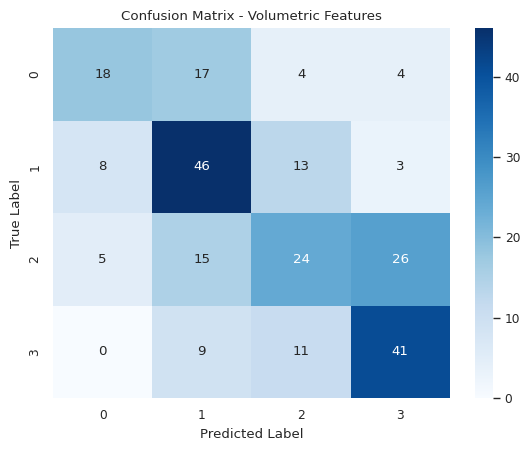


--- Shape Descriptors ---
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.21      0.31        43
           1       0.40      0.60      0.48        70
           2       0.51      0.49      0.50        70
           3       0.73      0.67      0.70        61

    accuracy                           0.52       244
   macro avg       0.55      0.49      0.50       244
weighted avg       0.54      0.52      0.51       244



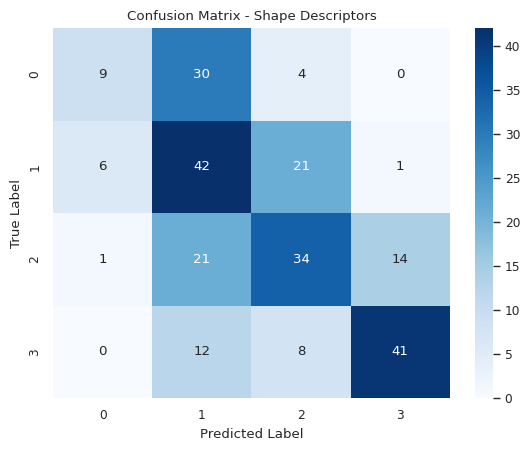

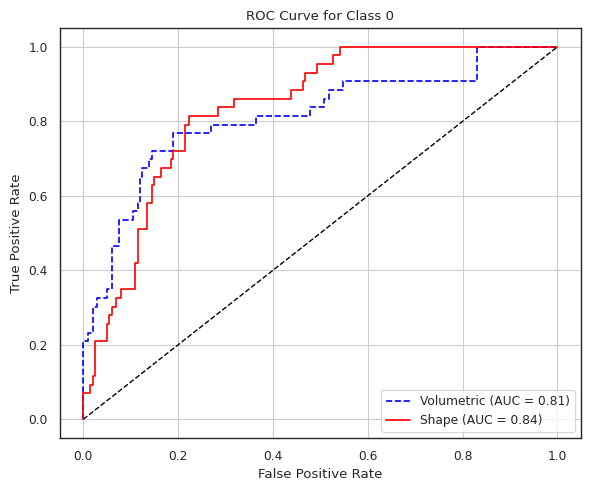

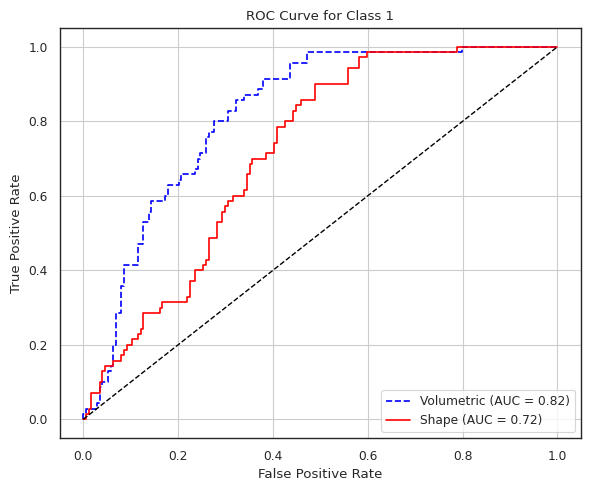

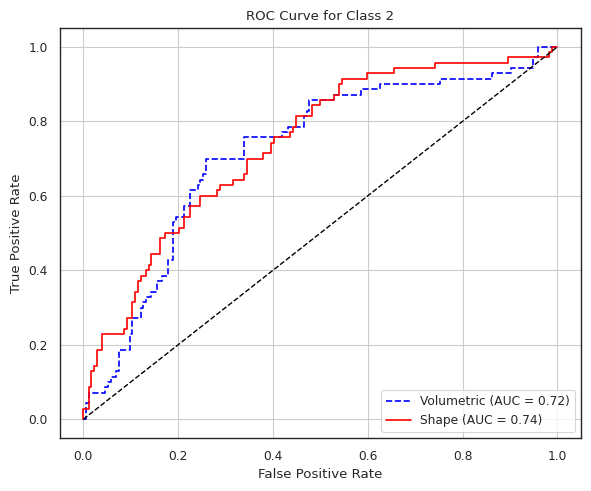

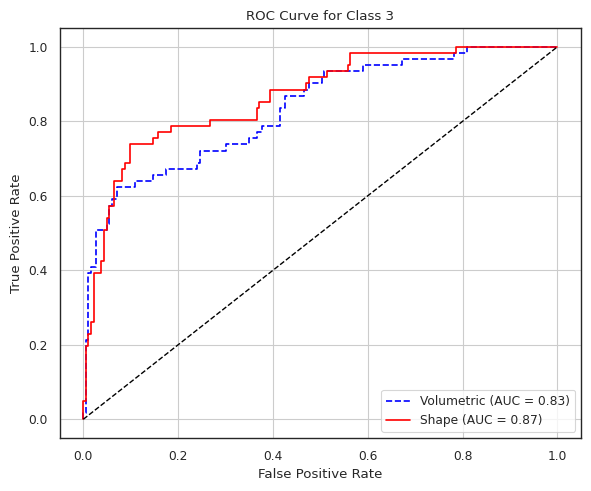

In [100]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from datetime import datetime
import time

def train_and_get_roc(X_train_feats, y_train, X_test_feats, y_test, label):
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_feats)
    X_test_scaled = scaler.transform(X_test_feats)

    # Train classifier
    clf = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Predict
    y_pred = clf.predict(X_test_scaled)
    print(f"\n--- {label} ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {label}")
    time.sleep(1)
    plt.savefig(datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".svg")
    plt.show()

    # ROC data
    present_classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=present_classes)
    y_score = clf.predict_proba(X_test_scaled)

    class_indices = [list(clf.classes_).index(c) for c in present_classes]
    y_score = y_score[:, class_indices]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    if len(present_classes) > 1:
        for i, c in enumerate(present_classes):
            fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[c] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

        return fpr, tpr, roc_auc, present_classes
    else:
        print("ROC AUC is undefined: only one class present in test set.")
        return None, None, None, []

### 1. Volumetric Features
features = ['Left-Lateral-Ventricle', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum']
X_train_vol = X_train[features]
X_test_vol = X_test[features]
y_train_vol = X_train['Disease_Stage']
y_test_vol = X_test['Disease_Stage']

fpr_vol, tpr_vol, roc_auc_vol, classes_vol = train_and_get_roc(X_train_vol, y_train_vol, X_test_vol, y_test_vol, "Volumetric Features")

### 2. Shape Descriptors
X_train_shape = global_features_array_train
X_test_shape = global_features_array_test
y_train_shape = disease_stage_array_train
y_test_shape = disease_stage_array_test

fpr_shape, tpr_shape, roc_auc_shape, classes_shape = train_and_get_roc(X_train_shape, y_train_shape, X_test_shape, y_test_shape, "Shape Descriptors")

### 3. Plot ROC curves for each class separately
if fpr_vol and fpr_shape:
    shared_classes = sorted(set(classes_vol) & set(classes_shape))
    for c in shared_classes:
        plt.figure(figsize=(6, 5))
        plt.plot(fpr_vol[c], tpr_vol[c], label=f'Volumetric (AUC = {roc_auc_vol[c]:.2f})',linestyle='--', color='blue')
        plt.plot(fpr_shape[c], tpr_shape[c], label=f'Shape (AUC = {roc_auc_shape[c]:.2f})', color='red')
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Class {c}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        time.sleep(1)
        plt.savefig(datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".svg")
        plt.show()
